<a href="https://colab.research.google.com/github/urvog/LLMcallclassifier/blob/main/20230913_llama_2_13b_chat_Intent_Classification_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/llm-field-guide/llama-2/llama-2-70b-chat-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/llm-field-guide/llama-2/llama-2-70b-chat-agent.ipynb)

# LLaMa 13B Chatbot in Hugging Face and LangChain

In this notebook we'll explore how we can use the open source **Llama-13b-chat** model in both Hugging Face transformers and LangChain.
At the time of writing, you must first request access to Llama 2 models via [this form]() (access is typically granted within a few hours).

---

🚨 _Note that running this on CPU is practically impossible. It will take a very long time. If running on Google Colab you go to **Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > A100**. Using this notebook requires ~38GB of GPU RAM._

---

We start by doing a `pip install` of all required libraries.

In [ ]:
!pip install -qU \
    transformers==4.31.0 \
    accelerate==0.21.0 \
    einops==0.6.1 \
    langchain==0.0.240 \
    xformers==0.0.20 \
    bitsandbytes==0.41.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.1 MB/s eta 0:00:00


# Initializing the Hugging Face Pipeline

The first thing we need to do is initialize a `text-generation` pipeline with Hugging Face transformers. The Pipeline requires three things that we must initialize first, those are:

* A LLM, in this case it will be `meta-llama/Llama-2-13b-chat-hf`.

* The respective tokenizer for the model.

We'll explain these as we get to them, let's begin with our model.

We initialize the model and move it to our CUDA-enabled GPU. Using Colab this can take 5-10 minutes to download and initialize the model.

In [ ]:
from torch import cuda, bfloat16
import transformers

model_id = 'meta-llama/Llama-2-13b-chat-hf'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

# begin initializing HF items, need auth token for these
hf_auth = 'ENTER YOUR HUGGINGFACE KEY'
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=hf_auth
)
model.eval()
print(f"Model loaded on {device}")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded on cuda:0


The pipeline requires a tokenizer which handles the translation of human readable plaintext to LLM readable token IDs. The Llama 2 13B models were trained using the Llama 2 13B tokenizer, which we initialize like so:

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


# Classification Inference

Now we're ready to initialize the HF pipeline. There are a few additional parameters that we must define here. Comments explaining these have been included in the code.

In [ ]:
import torch

generate_text = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    return_full_text=True,  # langchain expects the full text
    task='text-generation', # task type
    temperature=0.0,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    max_new_tokens=512,  # mex number of tokens to generate in the output
    repetition_penalty=1.1,  # without this output begins repeating
)

Now to implement this in LangChain

In [ ]:
from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate,  LLMChain
import pandas as pd
import numpy as np

llm = HuggingFacePipeline(pipeline=generate_text)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!wget https://neuraldojo.org/cognicall/data/intention_calls_health.xlsx
!wget https://neuraldojo.org/cognicall/data/transcripts_health_2021.csv

--2023-09-14 20:28:53--  https://neuraldojo.org/cognicall/data/intention_calls_health.xlsx
Resolving neuraldojo.org (neuraldojo.org)... 143.95.32.198
Connecting to neuraldojo.org (neuraldojo.org)|143.95.32.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17293 (17K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘intention_calls_health.xlsx’

intention_calls_hea 100%[===================>]  16.89K  --.-KB/s    in 0.02s   

2023-09-14 20:28:53 (730 KB/s) - ‘intention_calls_health.xlsx’ saved [17293/17293]

--2023-09-14 20:28:53--  https://neuraldojo.org/cognicall/data/transcripts_health_2021.csv
Resolving neuraldojo.org (neuraldojo.org)... 143.95.32.198
Connecting to neuraldojo.org (neuraldojo.org)|143.95.32.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2963847 (2.8M) [text/csv]
Saving to: ‘transcripts_health_2021.csv’

transcripts_health_ 100%[===================>]   2.83M  --.-KB/s    in 0.1s  

We still get the same output as we're not really doing anything differently here, but we have now added **Llama 2 70B Chat** to the LangChain library. Using this we can now begin using LangChain's advanced agent tooling, chains, etc, with **Llama 2**.

In [ ]:
df_transcripts = pd.read_csv("transcripts_health_2021.csv")

In [ ]:
df_intention = pd.read_excel("intention_calls_health.xlsx")

# Prompts Templates

In [ ]:
def get_category_by_id(id_num,df):
    category = df[df['ID'] == id_num]['Intention Call Categories'].values
    if len(category) > 0:
        return category[0]
    else:
        return "ID not found"

def get_id_by_category(category_text,df):
    id_num = df[df['Intention Call Categories'] == category_text]['ID'].values
    if len(id_num) > 0:
        return id_num[0]
    else:
        return "Category not found"

## Prompt1

In [ ]:
prompt_template = """Summarize the next call text in one paragraph:

                      {text}

                      The output will be a short sentence.

                      """

llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template),
    verbose=True
)

output = llm_chain.predict(text=df_transcripts['call_transcript'][3])
print("Predict:",output, ",Real:",df_transcripts['intention'][3])



> Entering new LLMChain chain...
Prompt after formatting:
Summarize the next call text in one paragraph:

                      Agent 2: Thank you for calling ElectricVolt, my name is Agent 2. How may I assist you today?

Customer: Hi Agent 2, my name is Sarah Johnson. I'm experiencing an electrical outage in my residential area. Can you please help me?

Agent 2: Of course, Sarah! I'm sorry to hear about the outage. Let me check if there are any reported outages in your area. Can you please provide me with your address?

Customer: Sure! I live at 123 Main Street, Anytown.

Agent 2: Thank you, Sarah. Let me just pull up the information for you. It seems like there's currently an outage in your area due to a fallen tree on the power lines. Our team is already working on it, and we expect the power to be restored within the next hour. I apologize for the inconvenience caused.

Customer: Oh, that's great to hear! Thank you for the quick response. Is there anything else I should do while 

## Prompt 2

In [ ]:
prompt_template = """ Classify the following text:

                      {text}

                      into one of the following categories:

                      {intentions}

                      The output will be one category text only.

                      Answer:

                      """

llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template),
    verbose=True
)

#output = llm_chain.predict(text=df_transcripts['call_transcript'][9],intentions=df_intention['Intention Call Categories'].values)
output = llm_chain.predict(text=df_transcripts['call_transcript'][10],intentions=list(df_intention['Intention Call Categories']))
print("Predict:",output, ",Real:",df_transcripts['intention'][10],", Real ID",get_id_by_category(df_transcripts['intention'][10],df_intention))



> Entering new LLMChain chain...
Prompt after formatting:
 Classify the following text:

                      Agent 1: Thank you for calling HealthHarbor, my name is Agent 1. How can I assist you today?

Customer: Hi, Agent 1. My name is Emily Smith. I'm feeling really scared right now and I need some help regarding my insurance and billing inquiries.

Agent 1: Hi, Emily. I'm here to help you. I understand that dealing with insurance and billing can be overwhelming. Don't worry, we'll find a solution together. Can you please provide me with your insurance information?

Customer: Sure, I have insurance through XYZ Insurance Company. My policy number is 123456789.

Agent 1: Thank you, Emily. Let me look up your information. Okay, I see that you are covered under our network. How can I assist you with your billing inquiries?

Customer: Well, I recently received a bill from the hospital and I'm confused about some of the charges. Can you help me understand them?

Agent 1: Of course, Emi

# Prompt Classification

## Basic Prompt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

prompt_template = """Classify the following transcript call text:

                      {text}

                      Into one of the following intention categories call:

                      {intentions}

                      The output will be only the ID number

                      Answer:

                      """

llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template),
    verbose=False
)

intention_predict = []
total_rows = 200
n_transcript = 1
for index, row in df_transcripts.iloc[0:total_rows].iterrows():
  transcript = row['call_transcript']
  intention_real = row['intention']
  output = llm_chain.predict(text=transcript,intentions=df_intention[['ID','Intention Call Categories']].values)
  print("Transcript number:",n_transcript)
  #print("Predict:",output, "Real:",intention_real)
  intention_predict.append(output)
  n_transcript+=1

Transcript number: 1
Transcript number: 2
Transcript number: 3
Transcript number: 4
Transcript number: 5
Transcript number: 6
Transcript number: 7
Transcript number: 8
Transcript number: 9
Transcript number: 10
Transcript number: 11
Transcript number: 12
Transcript number: 13
Transcript number: 14
Transcript number: 15
Transcript number: 16
Transcript number: 17
Transcript number: 18
Transcript number: 19
Transcript number: 20
Transcript number: 21
Transcript number: 22
Transcript number: 23
Transcript number: 24
Transcript number: 25
Transcript number: 26
Transcript number: 27
Transcript number: 28
Transcript number: 29
Transcript number: 30
Transcript number: 31
Transcript number: 32
Transcript number: 33
Transcript number: 34
Transcript number: 35
Transcript number: 36
Transcript number: 37
Transcript number: 38
Transcript number: 39
Transcript number: 40
Transcript number: 41
Transcript number: 42
Transcript number: 43
Transcript number: 44
Transcript number: 45
Transcript number: 

## Advanced Prompt

In [ ]:

print(list("Category: "+df_intention['Intention Call Categories']+"\nDefinition:"+df_intention['Definition or Description']+"\n"))

['Category: Appointment Scheduling\nDefinition:Patients call to schedule, reschedule, or cancel appointments with healthcare providers, specialists, or diagnostic facilities.\n', 'Category: Medical Advice or Symptom Assessment\nDefinition:Patients seek guidance on managing symptoms, minor medical conditions, or want to know if they need to visit a doctor.\n', 'Category: Medication Refills and Prescription Inquiries\nDefinition:Patients request refills for their medications or inquire about prescription status, dosage, and interactions.\n', 'Category: Insurance and Billing Inquiries\nDefinition:Patients may have questions about their insurance coverage, claims, billing, or payment options.\n', 'Category: Lab and Test Results\nDefinition:Patients call to inquire about their test results, such as blood work, X-rays, or other diagnostic tests.\n', 'Category: Referrals and Specialist Appointments\nDefinition:Patients may require assistance in getting referrals to see a specialist or getting

In [ ]:
import warnings
warnings.filterwarnings('ignore')

prompt_template = """
                      You are an especialist in a call center for electrical company.

                      Classify the following call transcript:

                      {text}

                      into one of the following categories:

                      {intentions}

                      The output will be one category text only.

                      Answer:

                      """

llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template),
    verbose=False
)

intention_predict = []
total_rows = 1000
n_transcript = 1
good_predict = 0
for index, row in df_transcripts.iloc[0:total_rows].iterrows():
  transcript = row['call_transcript']
  intention_real = row['intention']
  output = llm_chain.predict(text=transcript,intentions=list(df_intention['Intention Call Categories']))

  print("Transcript number:",n_transcript,", Predict:",output, ",Real:",intention_real)
  if intention_real in output:
    good_predict+=1
    print("YES")
    intention_predict.append(intention_real)
  else:
    print("NO")
    intention_predict.append(output)

  n_transcript+=1

Transcript number: 1 , Predict:  ['Medical Advice or Symptom Assessment'] ,Real: Medical Advice or Symptom Assessment
YES
Transcript number: 2 , Predict:  ['General Inquiries'] ,Real: General Inquiries
YES
Transcript number: 3 , Predict:  Lab and Test Results ,Real: Lab and Test Results
YES
Transcript number: 4 , Predict:  Follow-up Calls and Care Management ,Real: Follow-up Calls and Care Management
YES
Transcript number: 5 , Predict:  ['Medication Refills and Prescription Inquiries'] ,Real: Medication Refills and Prescription Inquiries
YES
Transcript number: 6 , Predict:  Lab and Test Results ,Real: Lab and Test Results
YES
Transcript number: 7 , Predict:  ['Follow-up Calls and Care Management'] ,Real: Follow-up Calls and Care Management
YES
Transcript number: 8 , Predict:  Follow-up Calls and Care Management ,Real: Follow-up Calls and Care Management
YES
Transcript number: 9 , Predict:  ['Medical Advice or Symptom Assessment'] ,Real: Medication Refills and Prescription Inquiries
NO


In [ ]:
good_predict

849

# Model Metrics

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
l_intention_predict = intention_predict
l_intention_test = df_transcripts['intention'].iloc[0:total_rows].tolist()

In [ ]:
accuracy = accuracy_score(l_intention_test, l_intention_predict)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


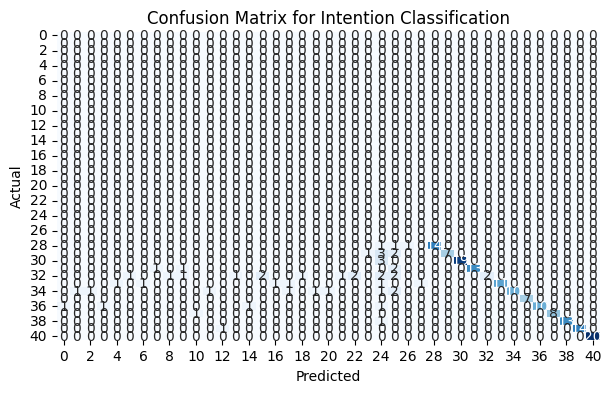

In [ ]:
#confusion matrix
cm = confusion_matrix(l_intention_test, l_intention_predict)

#plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Intention Classification')
plt.show()


#Saving Predictions List

In [ ]:
import datetime

now = datetime.datetime.now()
now = now.strftime("%Y%m%d%H%M%S")

df_prediction = pd.DataFrame(df_transcripts.iloc[0:total_rows]['call_transcript'].values,intention_predict).reset_index()
df_prediction['Real'] = df_transcripts.iloc[0:total_rows]['intention']
df_prediction.columns = ['Prediction','Transcription',"Real"]
df_prediction.head(50)
#generate vairla

df_prediction.to_csv('llama2_prediction_hc_1000rows_'+now+'.csv')
